# 02807 Computational Tools for Data Science 2022: Analyzing H\&M Fashion Buying Patterns

## Notebook prepared by Soren Johansen. s141410. Danish Technical University. 

In [2]:
import pandas as pd
import numpy as np
import csv
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
import warnings 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib as mpl
import time

In [3]:
import networkx as nx

In [4]:
warnings.filterwarnings('ignore')

# Content:
## Define functions for analysis
## Import and join dataframes
## Top selling Products
## Purchases over time
## Correlation
## Complexity of Apriori method
## Aprori Analysis
### Age 20-30
### Age 30-40
### Age above 40

## Define functions for analysis

All the calculations is defined as a function. 

In [5]:
def topselling(top):
    topprod=newdf.product_type_name.value_counts()
    dftop = topprod.head(top)
    return dftop.plot.bar(dftop,title='Top selling products')

In [6]:
def age_select(age):
    if (age>=20 and age<30): return 'age20_30'
    elif (age>=30 and age<40): return 'age30_40'
    else : return 'other'

In [7]:
def age_top_selling(top):
    newdf['agecat']=newdf['age'].map(age_select)
    subsetflag=newdf.agecat=='other'
    dfage20_40=newdf[-subsetflag]
    onlydf=dfage20_40[['product_type_name','agecat']]
    only=onlydf.groupby('agecat')['product_type_name'].value_counts().reset_index(name='Count')
    topprod=only.product_type_name.head(top)
    plt.tick_params(axis='both', which='major', labelsize=8)
    return sns.barplot(data=only[only.product_type_name.isin(topprod)],x='Count',y='product_type_name', orient='h',hue='agecat')

In [8]:
def product_time(prod='Sweater'):
    mask=newdf.product_type_name==prod
    prod_time=newdf[mask]
    df1 = prod_time.groupby(prod_time['t_dat']).size().reset_index(name='Count')
    fig, ax = plt.subplots(figsize = (12,6))    
    ax.set_xticklabels(labels=df1.t_dat, rotation=45, ha='right')
    fig=sns.scatterplot(data=df1, x="t_dat", y="Count").set_title('Number of Purchases of Product over time span')
    x_dates = df1['t_dat'].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
    #return sns.scatterplot(data=df1, x="t_dat", y="Count").set_title('Number of Purchases of Product over time span')
    return fig

In [9]:
def prod_corr(topXprods=10):
    topprod=newdf.product_type_name.value_counts()
    list_topX=topprod.head(topXprods)
    t=newdf[newdf.product_type_name.isin(list_topX.index)]
    t_new=t[['t_dat','product_type_name']]
    y=t_new.groupby(['t_dat','product_type_name']).size().reset_index(name='Count')
    y_new=y.pivot_table(columns=['product_type_name'],index='t_dat', values='Count')
    #fig = px.imshow(y_new.corr(),title='Correlation Between Products')
    ax = plt.axes()
    ax.set_title('Correlation Between Products')
    return sns.heatmap(y_new.corr())

In [10]:
def aprio(df,minsup=0.001):
    apo=apriori(df, min_support=minsup, use_colnames=True)
    apo['length'] = apo['itemsets'].apply(lambda x: len(x))
    apo=apo.sort_values(by=['support'],ascending=False)
    return apo

In [11]:
def freqitm(df,minsup):
    frequent_itemsets = fpgrowth(df, min_support=minsup,use_colnames=True)
    frequent_itemsets= frequent_itemsets.sort_values(by=['support'],ascending=False)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    return frequent_itemsets

In [12]:
def newcol(df):
    temp=df.copy()
    temp['new_column'] = temp['itemsets'].apply(set)
    temp.new_column=temp.new_column.astype("string")
    temp=temp[temp.length==1]
    temp['prod_name'] = temp['new_column'].str.split('_').str[0]
    #freq2items['color'] = freq2items['new_column'].str.split('_').str[1]
    temp['pattern'] = temp['new_column'].str.split('_').str[1]
    temp['prod_name']=temp['prod_name'].str.replace('{','')
    temp['pattern']=temp['pattern'].str.replace('}','')
    temp['prod_name']=temp['prod_name'].str.replace('\'','')
    temp['pattern']=temp['pattern'].str.replace('\'','')
    return temp

In [13]:
def apo_rules(frequent_itemsets):
    apriori_rules=association_rules(frequent_itemsets, metric="lift", min_threshold=0.1)
    #apriori_rules=apriori_rules.sort_values('confidence', ascending = False, inplace = True)
    return apriori_rules

In [14]:
#Function to sample frac% of customers

def sample_cust(data, frac):
    b=data.customer_id.sample(frac=frac)
    return data.loc[b.index]

In [15]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "GB"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   #print(i)
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

## Import data and join dataframes

In [16]:
df_cust=pd.read_csv('./data/customers.csv')

In [17]:
df_cust.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [18]:
df_articles=pd.read_csv('./data/articles.csv')

In [19]:
df_articles.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [20]:
df_articles.prod_name.unique().shape

(45875,)

In [21]:
df_articles.index_group_name.unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [22]:
df_articles.product_type_name.unique().shape

(131,)

In [23]:
df_trans=pd.read_csv('./data/transactions_train.csv')

In [24]:
df_trans.shape

(31788324, 5)

In [25]:
df_trans.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [26]:
df_trans['t_dat'] = pd.to_datetime(df_trans['t_dat'])

In [27]:
df_trans.t_dat.min()

Timestamp('2018-09-20 00:00:00')

In [28]:
df_trans.t_dat.max()

Timestamp('2020-09-22 00:00:00')

Time span in days

In [29]:
spandays=(df_trans.t_dat.max()-df_trans.t_dat.min())

In [30]:
print('Span in Years',spandays / np.timedelta64(1, 'Y'))

Span in Years 2.006885836122576


On transaction data frame join the articles data frame

In [31]:
newdf=df_trans.merge(df_articles,on='article_id', how='left')

In [32]:
newdf.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."


And finaly join the customer data frame to dataframe

In [33]:
newdf=newdf.merge(df_cust,on='customer_id', how='left')

In [34]:
#product categories 
newdf.product_group_name.unique()

array(['Underwear', 'Garment Upper body', 'Garment Lower body',
       'Accessories', 'Socks & Tights', 'Shoes', 'Garment Full body',
       'Nightwear', 'Swimwear', 'Underwear/nightwear', 'Cosmetic',
       'Unknown', 'Items', 'Bags', 'Interior textile', 'Furniture',
       'Garment and Shoe care', 'Stationery', 'Fun'], dtype=object)

The data frame is final 'joined' dataframe.


The variable 'index_group_name' can be a proxy for sex.

In [35]:
newdf.index_group_name.value_counts()

Ladieswear       20415260
Divided           7138254
Menswear          1771053
Sport             1246408
Baby/Children     1217349
Name: index_group_name, dtype: int64

Add agegroup variable to the dataframe derived from the age. 

In [36]:
bins= [0,10,20,30,40,50,60,70,80,90,100]
#labels = ['Teen','Young Adult', 'Adult']
newdf['AgeGroup'] = pd.cut(newdf['age'], bins=bins, right=True)


In [37]:

ag = newdf.groupby('index_group_name').AgeGroup.value_counts().sort_index()

In [38]:
ag.unstack()

AgeGroup,"(0, 10]","(10, 20]","(20, 30]","(30, 40]","(40, 50]","(50, 60]","(60, 70]","(70, 80]","(80, 90]","(90, 100]"
index_group_name,,,,,,,,,,
Baby/Children,0,20698,213336,378524,432052,124946,31381,5490,397,9
Divided,0,499284,3302778,1089523,1119271,907514,163792,24494,2043,254
Ladieswear,0,839648,8716621,3657362,3132015,3122457,727597,124593,7909,847
Menswear,0,70808,666335,264962,334316,353188,64148,8304,518,63
Sport,0,41715,562056,238828,197483,171928,25804,2552,174,49


Final dimensions of the data file 

In [39]:
newdf.shape

(31788324, 36)

In [40]:
#newdf.dtypes

In [41]:
len(newdf.prod_name.unique())

45508

In [42]:
newdf.head(3)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,AgeGroup
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa...",NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(20, 30]"
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,...,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa...",NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"(20, 30]"
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,505221,Inca Jumper,252,Sweater,Garment Upper body,...,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,"(30, 40]"


Hannahs Filter

In [43]:
newdf = newdf[newdf.colour_group_name != 'Black' ]
newdf = newdf[newdf.colour_group_name != 'White' ]
newdf = newdf[newdf.colour_group_name != 'Dark Blue' ]

newdf = newdf[newdf.product_type_name != 'Trousers' ]



In [44]:
newdf = newdf[newdf.groupby('product_type_name').product_type_name.transform(len) > 1000]


In [45]:
newdf = newdf.dropna()

newdf.head(4)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,garment_group_no,garment_group_name,detail_desc,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,AgeGroup
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,505221,Inca Jumper,252,Sweater,Garment Upper body,...,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,"(30, 40]"
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,"(30, 40]"
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,"(30, 40]"
5,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687001,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...,1.0,1.0,ACTIVE,Regularly,32.0,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...,"(30, 40]"


# Top Selling products

The most top ranking purchased products 

<AxesSubplot:title={'center':'Top selling products'}>

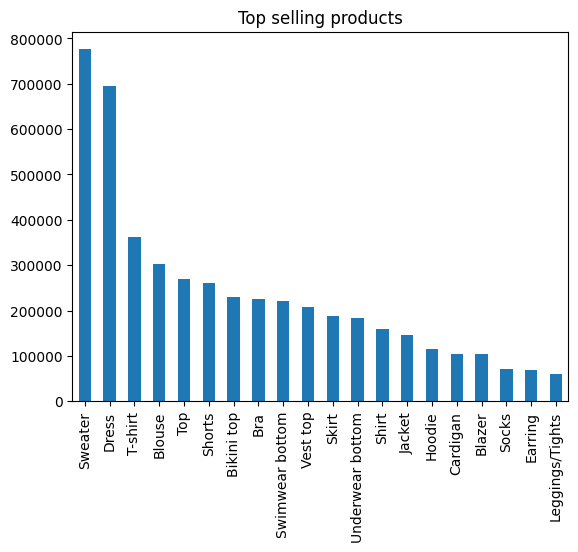

In [46]:
topselling(20)
#Top x=20 selling products across products

<AxesSubplot:xlabel='Count', ylabel='product_type_name'>

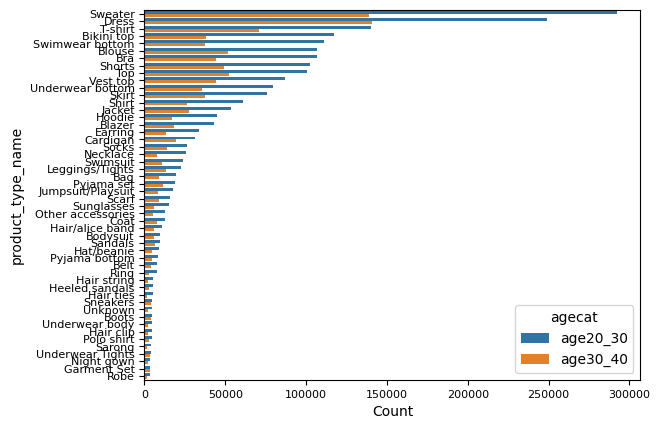

In [47]:
age_top_selling(50)
# By visual inspection we see a clear difference between the two age groups. 

# Correlation

<AxesSubplot:title={'center':'Correlation Between Products'}, xlabel='product_type_name', ylabel='product_type_name'>

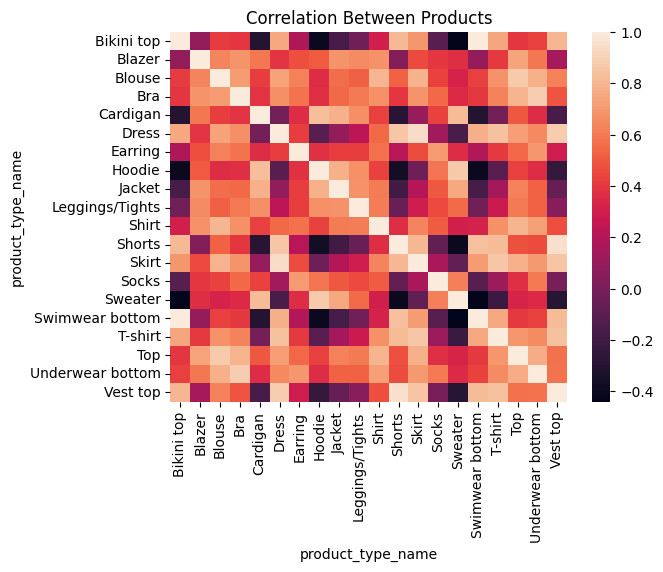

In [48]:
prod_corr(20)
# Interesting to see the positve correlation 'Bikini top' and 'T-shirt' (summer) and negative correlations 
# 'T-shirt' and 'Hoodie'

# Purchases over Time

Text(0.5, 1.0, 'Number of Purchases of Product over time span')

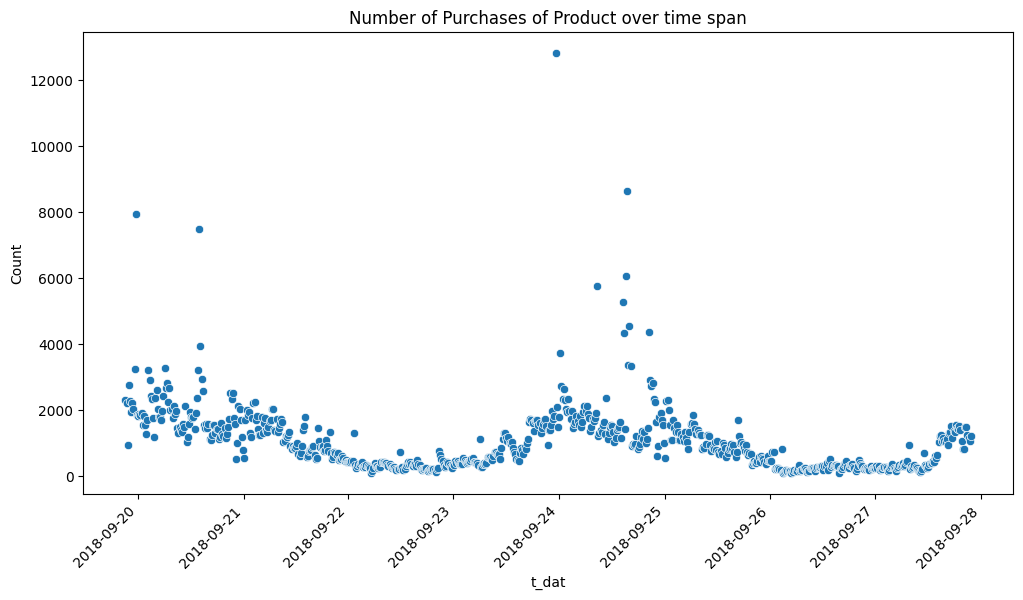

In [49]:
# T-shirt and Swimsuit Jacket Shorts
product_time('Sweater')
# See the seasonality pattern.

# Complexity of Apriori Method

On page 215 and 216 in the textbook it is shown how we can calculate the memory requirement.
For age group 20-30 (see further down in the notebook.
The number of rows in purchases_list is :

$$len(purchases\_list)= 1.002.741 \hspace{0.5cm} baskets $$

We can calculate the number of unique items in our dataset:

$$ len(testnew.product\_type\_name.unique())=131.440 $$

Note testnew is my input to purchases_list so it must be same number items in purchases_list.

The number of pairs is:

$$\binom{131.440}{ 2}$$

This is approximately 

$$\frac{131440^2}{2}=34.552.947.200   \hspace{0.5cm } store\hspace{0.1cm} space. $$

If integers take 4 bytes then it requires $2 \cdot items^2$ bytes.

This gives $2\cdot 131440^2=$  bytes and is equivalent to 32.18 Gigabytes. 

The big O complexity of the Apriori method has exponential complexity $O(2^D)$. 

In [66]:
#storespace=131440**2/2
storespace=83658**2/2
#print(storespace)
calc=2*131440**2

convert_size(calc)

'32.18 GB'

In [67]:
calc

34552947200

# Aprori Analysis

Only use variables t_dat, customer_id, prod_name and age. For use in aprori analysis below.

In [52]:
len(newdf.colour_group_name.unique())

47

In [53]:
len(newdf.graphical_appearance_name.unique())

30

In [54]:
#cols = ['product_type_name', 'colour_group_name', 'graphical_appearance_name']
#cols = ['product_type_name', 'graphical_appearance_name']
#cols = ['product_type_name', 'colour_group_name']
#newdf['combined'] = newdf[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [55]:
#select_newdf=newdf[['t_dat','customer_id','prod_name','age']]
#select_newdf=newdf[['t_dat','customer_id','combined','age']]
select_newdf=newdf[['t_dat','product_type_name','customer_id','age']]

In [56]:
select_newdf.head(3)

,t_dat,product_type_name,customer_id,age
2,2018-09-20,Sweater,00007d2de826758b65a93dd24ce629ed66842531df6699...,32.0
3,2018-09-20,Sweater,00007d2de826758b65a93dd24ce629ed66842531df6699...,32.0
4,2018-09-20,Sweater,00007d2de826758b65a93dd24ce629ed66842531df6699...,32.0


In [57]:
test = select_newdf.groupby(['customer_id', 't_dat','age'])['product_type_name'].apply(lambda x: ','.join(x.astype(str))).reset_index() 

In [58]:
testnew=pd.DataFrame(test)

In [59]:
testnew.head()

,customer_id,t_dat,age,product_type_name
0,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2019-03-07,52.0,"Bikini top,Swimwear bottom"
1,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-06-03,52.0,Underwear body
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,52.0,T-shirt
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,32.0,"Sweater,Sweater,Sweater,Sweater,Sweater"
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-23,32.0,"Underwear bottom,Underwear bottom"


In [60]:
len(testnew)

2543001

In [61]:
# I define the 4 different age groups
age20_30=testnew[(testnew.age>=20) & (testnew.age<30)]
age30_40=testnew[(testnew.age>=30) & (testnew.age<40)]
age40_50=testnew[(testnew.age>=40) & (testnew.age<50)]
age40_above=testnew[(testnew.age>=40)]

Number of customers betweeen age 20-30:

In [62]:
len(age20_30)

1002741

In [63]:
# Here I sample the data

#o20_30=sample_cust(age20_30,0.5)
#o30_40=sample_cust(age30_40,0.5)
#o40_50=sample_cust(age40_50,0.5)
#o_above40=sample_cust(age40_above,0.5)

o20_30=age20_30
o30_40=age30_40
o40_50=age40_50
o_above40=age40_above

This is the number of unique customers: 

In [68]:
print(len(o20_30))
print(len(o30_40))
print(len(o40_50))
print(len(o_above40))

1002741
428058
389945
1039207


This is the number of unique items in the customer dataset:

In [69]:
print(len(o20_30.product_type_name.unique()))
print(len(o30_40.product_type_name.unique()))
print(len(o_above40.product_type_name.unique()))

131440
83658
118335


In [70]:
# Only the basket
prods20_30=o20_30['product_type_name']
prods30_40=o30_40['product_type_name']
prods40_50=o40_50['product_type_name']
prods_above40=o_above40['product_type_name']
#prods_above40=o_above40['combined']


In [71]:
art20_30=prods20_30.values.tolist()
art30_40=prods30_40.values.tolist()
art40_50=prods40_50.values.tolist()
art40above=prods_above40.values.tolist()

In [72]:
print(art20_30[0])
print(art30_40[0])
print(art40_50[0])
print(art40above[0])

T-shirt
Sweater,Sweater,Sweater,Sweater,Sweater
Blouse
Bikini top,Swimwear bottom


The same function as Hannah

In [73]:
purchaseslist20_30 = [] 
purchaseslist30_40 = [] 
purchaseslist40_50 = []
purchaseslist40above = []

for i in art20_30:
    #print(i)
    purchaseslist20_30.append(i.split(",")) 



for i in art30_40:
    #print(i)
    purchaseslist30_40.append(i.split(",")) 

for i in art40_50:
    #print(i)
    purchaseslist40_50.append(i.split(",")) 

for i in art40above:
    #print(i)
    purchaseslist40above.append(i.split(",")) 

In [74]:
#Export the purchases_list to csv file

fields = ['BasketNew']
with open('o', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerow(fields)
    write.writerows(purchaseslist30_40)

In [75]:
#Sparse=True go in fit 
te = TransactionEncoder()
te_ary = te.fit(purchaseslist20_30).transform(purchaseslist20_30)
df20_30 = pd.DataFrame(te_ary,columns=te.columns_)


te_ary = te.fit(purchaseslist30_40).transform(purchaseslist30_40)
df30_40 = pd.DataFrame(te_ary,columns=te.columns_)

te_ary = te.fit(purchaseslist40_50).transform(purchaseslist40_50)
df40_50 = pd.DataFrame(te_ary,columns=te.columns_)


te_ary = te.fit(purchaseslist40above).transform(purchaseslist40above)
df40above = pd.DataFrame(te_ary,columns=te.columns_)


In [76]:
df20_30.head()


,Bag,Ballerinas,Beanie,Belt,Bikini top,Blazer,Blouse,Bodysuit,Bootie,Boots,...,Underwear Tights,Underwear body,Underwear bottom,Underwear set,Unknown,Vest top,Wallet,Watch,Waterbottle,Wedge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The above dimsions have really confused me !!!! The rows does not fit....But look below.

In [77]:
df20_30.shape

(1002741, 86)

## Age group 20-30

In [78]:
# Age 20-30
# 0.0001 too much
#import time
#start=time.time()
#apo=aprio(df20_30,0.01)
#elapsedtime=(time.time()-start)
#print('elapsed time',elapsedtime)

In [79]:
#apo

In [80]:
#age 20-30

#apo[apo.length==1]

In [81]:
# age 20-30
# the same as above but faster 
start=time.time()
freq20_30=freqitm(df20_30,0.0001)
elapsedtime=(time.time()-start)
print('elapsed time',elapsedtime)

elapsed time 4.072380304336548


In [82]:
freq20_30

,support,itemsets,length
13,0.201026,(Sweater),1
16,0.163250,(Dress),1
0,0.101735,(T-shirt),1
5,0.082735,(Blouse),1
4,0.082237,(Top),1
...,...,...,...
1975,0.000101,"(Dress, Bra, Necklace)",3
2773,0.000101,"(Dress, Polo shirt, Sweater)",3
2822,0.000101,"(Other shoe, Top)",2
294,0.000101,"(Swimwear bottom, Swimsuit, Dress, Bikini top,...",5


In [83]:
freq20_30.itemsets[13]

frozenset({'Sweater'})

In [85]:
#freq1items=freq20_30[freq20_30.length==1]

In [114]:
#freq1items

In [87]:
apo1=apo_rules(freq20_30).sort_values('support', ascending = False)

In [88]:
apo1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Swimwear bottom),(Bikini top),0.071797,0.075321,0.057987,0.807651,10.722846,0.052579,4.807291
1,(Bikini top),(Swimwear bottom),0.075321,0.071797,0.057987,0.769870,10.722846,0.052579,4.033391
2,(Bra),(Underwear bottom),0.081309,0.059479,0.025554,0.314282,5.283910,0.020718,1.371585
3,(Underwear bottom),(Bra),0.059479,0.081309,0.025554,0.429630,5.283910,0.020718,1.610693
4,(Dress),(Sweater),0.163250,0.201026,0.016844,0.103178,0.513259,-0.015974,0.890895
...,...,...,...,...,...,...,...,...,...
20392,"(Dress, Sweater)","(Bra, Shorts)",0.016844,0.003432,0.000101,0.005980,1.742592,0.000043,1.002564
20393,"(Dress, Bra)","(Shorts, Sweater)",0.006460,0.004244,0.000101,0.015591,3.673395,0.000073,1.011527
20394,"(Dress, Shorts)","(Bra, Sweater)",0.011404,0.008525,0.000101,0.008833,1.036119,0.000004,1.000311
20395,"(Bra, Sweater)","(Dress, Shorts)",0.008525,0.011404,0.000101,0.011816,1.036119,0.000004,1.000417


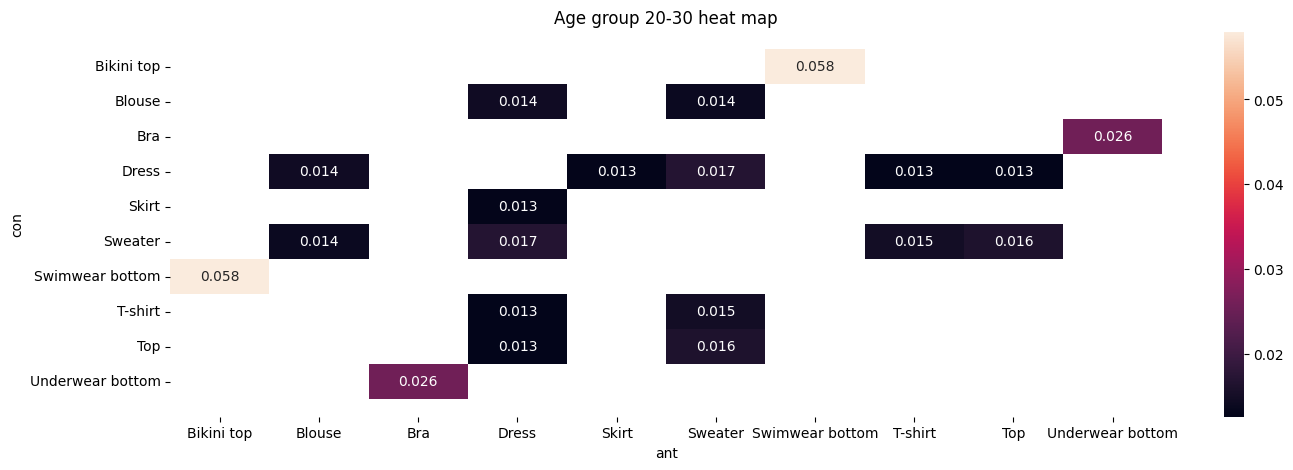

In [89]:
apo1ny=pd.DataFrame(apo1.head(20))

apo1ny['con']=apo1ny['consequents'].apply(lambda a: ','.join(list(a)))
apo1ny['ant']=apo1ny['antecedents'].apply(lambda a: ','.join(list(a)))

support_table = apo1ny.pivot(index='con', columns='ant', values='support')
plt.figure(figsize=(16,5))
sns.heatmap(support_table, annot=True, cbar=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.title('Age group 20-30 heat map')
plt.show() 

## Age group 30-40

In [90]:
#apo=aprio(df30_40,0.001)

In [91]:
#apo

In [92]:
#apo[apo.length>=2]

In [93]:
#age 30-40
freq30_40=freqitm(df30_40,0.0001)

In [94]:
freq30_40

,support,itemsets,length
0,0.207619,(Sweater),1
13,0.202816,(Dress),1
27,0.113337,(T-shirt),1
15,0.096209,(Top),1
9,0.089483,(Blouse),1
...,...,...,...
2411,0.000100,"(Swimwear bottom, Vest top, Bikini top, Blouse...",5
826,0.000100,"(Slippers, Sandals)",2
1297,0.000100,"(Coat, Jacket, Hoodie)",3
3608,0.000100,"(Scarf, T-shirt, Shorts)",3


In [95]:
apo2=apo_rules(freq30_40).sort_values('lift', ascending = False)

In [96]:
apo2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
29591,"(Bikini top, Bra)","(Swimwear bottom, Underwear bottom, Top)",0.003275,0.000236,0.000114,0.034950,148.125323,0.000114,1.035971
29582,"(Swimwear bottom, Underwear bottom, Top)","(Bikini top, Bra)",0.000236,0.003275,0.000114,0.485149,148.125323,0.000114,1.935946
21155,"(Swimwear bottom, Bra)","(Bikini top, Underwear bottom, Vest top)",0.003147,0.000325,0.000147,0.046771,144.032590,0.000146,1.048725
21154,"(Bikini top, Underwear bottom, Vest top)","(Swimwear bottom, Bra)",0.000325,0.003147,0.000147,0.453237,144.032590,0.000146,1.823192
29586,"(Bikini top, Underwear bottom, Top)","(Swimwear bottom, Bra)",0.000255,0.003147,0.000114,0.449541,142.858013,0.000114,1.810950
...,...,...,...,...,...,...,...,...,...
28226,(Coat),"(Swimwear bottom, Bikini top)",0.014820,0.041812,0.000119,0.008039,0.192267,-0.000501,0.965953
19928,(Swimwear bottom),(Coat),0.053789,0.014820,0.000152,0.002823,0.190482,-0.000645,0.987969
19929,(Coat),(Swimwear bottom),0.014820,0.053789,0.000152,0.010246,0.190482,-0.000645,0.956006
21541,(Bikini top),(Coat),0.054425,0.014820,0.000145,0.002661,0.179569,-0.000662,0.987808


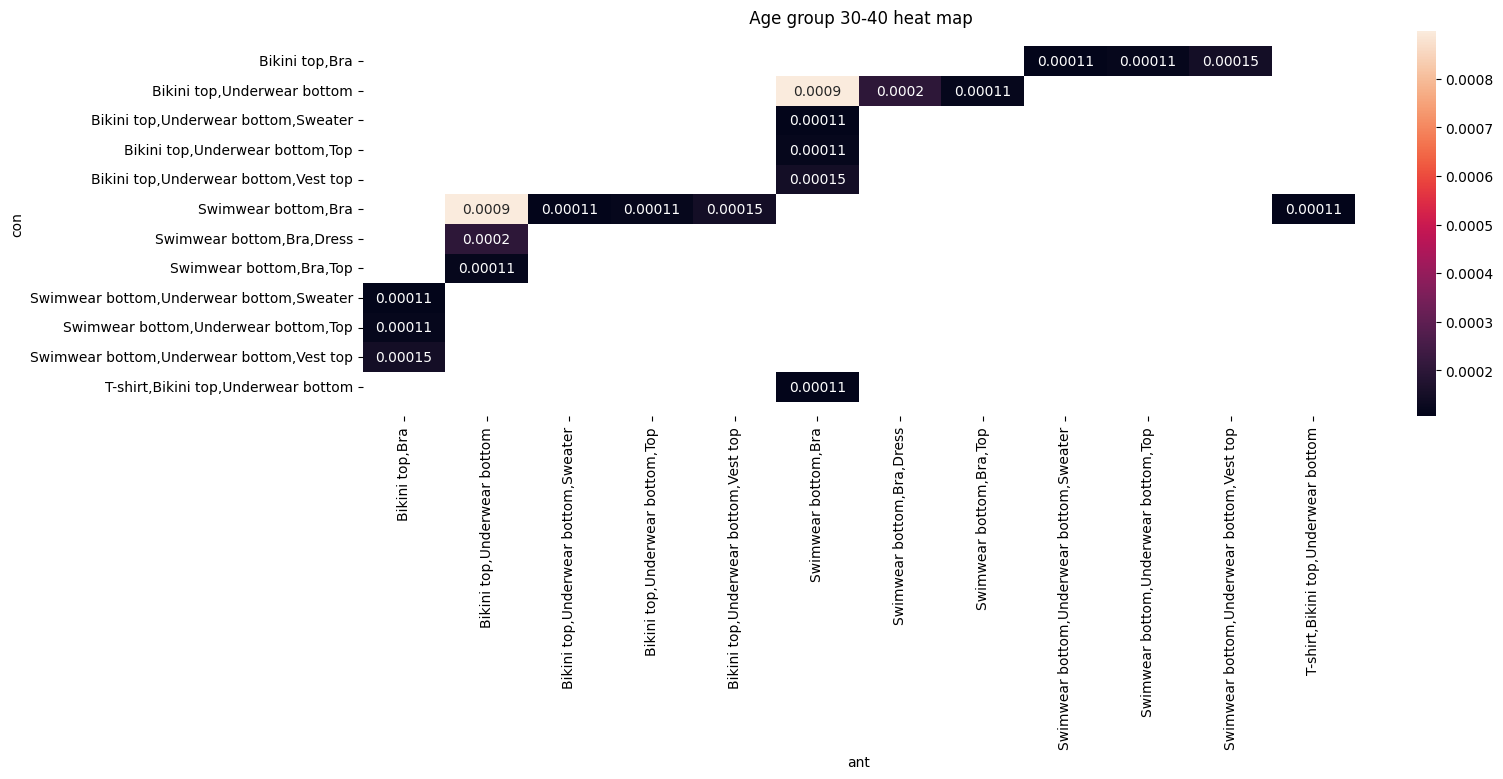

In [97]:
apo2ny=pd.DataFrame(apo2.head(20))
apo2ny['con']=apo2ny['consequents'].apply(lambda a: ','.join(list(a)))
apo2ny['ant']=apo2ny['antecedents'].apply(lambda a: ','.join(list(a)))

support_table = apo2ny.pivot(index='con', columns='ant', values='support')
plt.figure(figsize=(16,5))
sns.heatmap(support_table, annot=True, cbar=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.title(' Age group 30-40 heat map')
plt.show() 

## Age group 40-50

In [98]:
#apo=aprio(df40_50,0.001)

In [99]:
#apo

In [100]:
#apo[apo.length>=2]

In [101]:
freq40_50=freqitm(df40_50,0.0001)

In [102]:
freq40_50

,support,itemsets,length
5,0.210902,(Sweater),1
12,0.191122,(Dress),1
23,0.109813,(T-shirt),1
0,0.095657,(Blouse),1
6,0.084522,(Top),1
...,...,...,...
1817,0.000100,"(T-shirt, Hoodie, Shorts, Vest top)",4
873,0.000100,"(Dress, T-shirt, Cardigan, Skirt)",4
1462,0.000100,"(Blouse, Shirt, Jumpsuit/Playsuit)",3
1224,0.000100,"(Jacket, Shirt, Sweater, Top)",4


In [103]:
apo3=apo_rules(freq40_50).sort_values('lift', ascending = False)

In [104]:
apo3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11629,"(Swimwear bottom, Bra, Dress)","(Bikini top, Underwear bottom)",0.000413,0.001667,0.000128,0.310559,186.309126,0.000128,1.448033
11648,"(Bikini top, Underwear bottom)","(Swimwear bottom, Bra, Dress)",0.001667,0.000413,0.000128,0.076923,186.309126,0.000128,1.082886
11638,"(Dress, Bikini top, Underwear bottom)","(Swimwear bottom, Bra)",0.000333,0.002246,0.000128,0.384615,171.208728,0.000127,1.621349
11639,"(Swimwear bottom, Bra)","(Dress, Bikini top, Underwear bottom)",0.002246,0.000333,0.000128,0.057078,171.208728,0.000127,1.060179
15280,"(Bikini top, Underwear bottom)","(Swimwear bottom, Bra, Shorts)",0.001667,0.000374,0.000105,0.063077,168.469389,0.000105,1.066924
...,...,...,...,...,...,...,...,...,...
14507,(Swimwear bottom),"(Hoodie, Sweater)",0.045622,0.013097,0.000108,0.002361,0.180265,-0.000490,0.989239
3190,(Bikini top),(Hoodie),0.047186,0.045645,0.000362,0.007663,0.167884,-0.001792,0.961725
3191,(Hoodie),(Bikini top),0.045645,0.047186,0.000362,0.007922,0.167884,-0.001792,0.960422
5074,"(Swimwear bottom, Bikini top)",(Hoodie),0.035402,0.045645,0.000251,0.007099,0.155524,-0.001365,0.961178


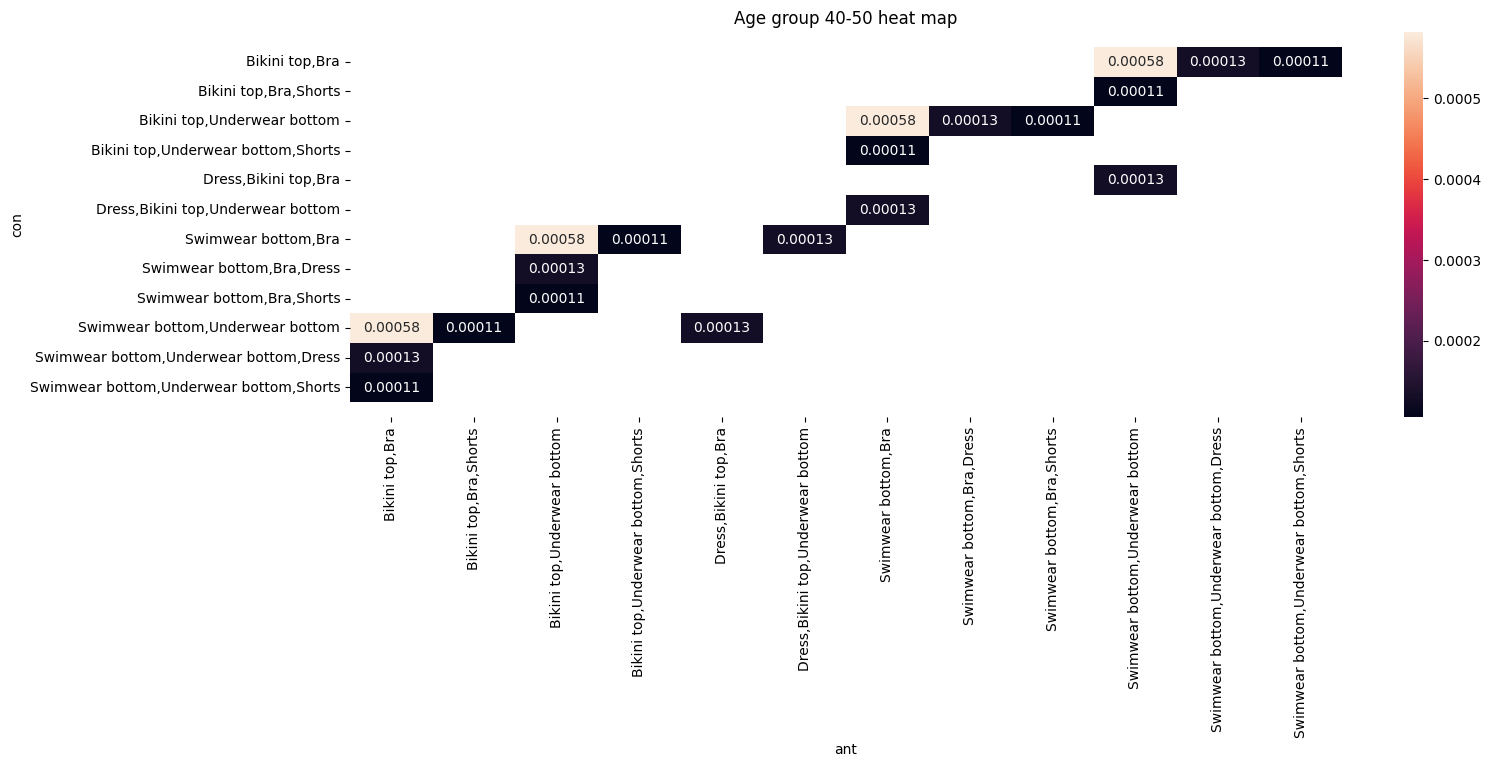

In [105]:
apo3ny=pd.DataFrame(apo3.head(20))
apo3ny['con']=apo3ny['consequents'].apply(lambda a: ','.join(list(a)))
apo3ny['ant']=apo3ny['antecedents'].apply(lambda a: ','.join(list(a)))
support_table = apo3ny.pivot(index='con', columns='ant', values='support')
plt.figure(figsize=(16,5))
sns.heatmap(support_table, annot=True, cbar=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.title('Age group 40-50 heat map')
plt.show() 

## Age group above 40

In [106]:
#apo=aprio(df40above,0.001)

In [107]:
#apo

In [108]:
#apo[apo.length>=2]

In [109]:
freq40above=freqitm(df40above,0.0001)

In [110]:
freq40above

,support,itemsets,length
4,0.216634,(Sweater),1
16,0.191834,(Dress),1
5,0.105129,(Blouse),1
3,0.097700,(T-shirt),1
7,0.087038,(Top),1
...,...,...,...
440,0.000100,"(Jacket, Sneakers, Sweater)",3
1845,0.000100,"(Unknown, Jacket)",2
592,0.000100,"(Dress, Blouse, Hoodie, Sweater)",4
2103,0.000100,"(Hat/brim, Shirt)",2


In [111]:
apo4=apo_rules(freq40above).sort_values('lift', ascending = False)

In [112]:
apo4

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1690,"(Bikini top, Underwear bottom)","(Swimwear bottom, Bra)",0.001291,0.001822,0.000459,0.355440,195.126975,0.000457,1.548619
1687,"(Swimwear bottom, Bra)","(Bikini top, Underwear bottom)",0.001822,0.001291,0.000459,0.251981,195.126975,0.000457,1.335138
1688,"(Swimwear bottom, Underwear bottom)","(Bikini top, Bra)",0.001353,0.001926,0.000459,0.339260,176.104741,0.000456,1.510540
1689,"(Bikini top, Bra)","(Swimwear bottom, Underwear bottom)",0.001926,0.001353,0.000459,0.238262,176.104741,0.000456,1.311011
9917,"(Swimwear bottom, Dress, Top)","(Bikini top, Blouse)",0.000520,0.001811,0.000111,0.212963,117.594369,0.000110,1.268287
...,...,...,...,...,...,...,...,...,...
3911,(Cardigan),"(Swimwear bottom, Bikini top)",0.041016,0.030208,0.000244,0.005959,0.197271,-0.000995,0.975606
467,(Sweater),"(Swimwear bottom, Bikini top)",0.216634,0.030208,0.001285,0.005930,0.196307,-0.005259,0.975577
462,"(Swimwear bottom, Bikini top)",(Sweater),0.030208,0.216634,0.001285,0.042527,0.196307,-0.005259,0.818159
286,(Bikini top),(Sweater),0.040390,0.216634,0.001709,0.042312,0.195315,-0.007041,0.817976


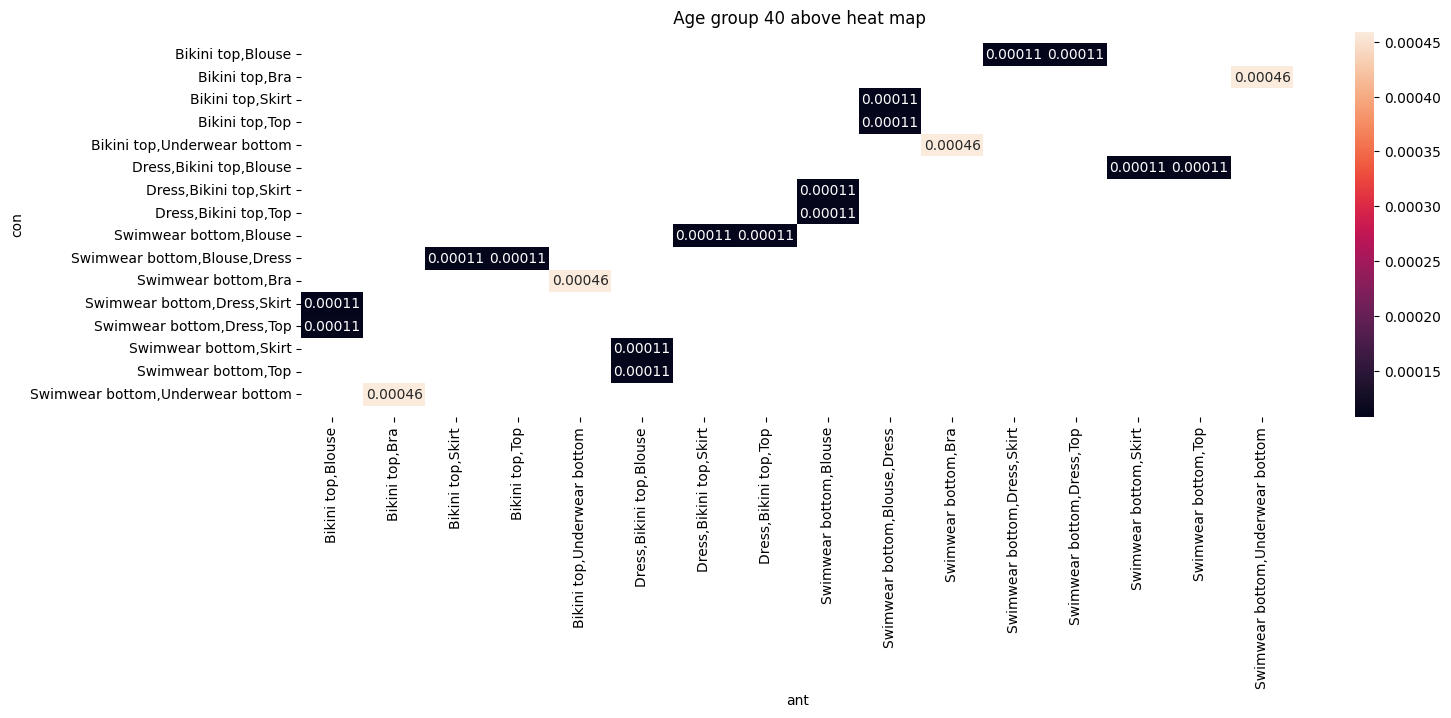

In [113]:
apo4ny=pd.DataFrame(apo4.head(20))
apo4ny['con']=apo4ny['consequents'].apply(lambda a: ','.join(list(a)))
apo4ny['ant']=apo4ny['antecedents'].apply(lambda a: ','.join(list(a)))
support_table = apo4ny.pivot(index='con', columns='ant', values='support')
plt.figure(figsize=(16,5))
sns.heatmap(support_table, annot=True, cbar=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.title(' Age group 40 above heat map')
plt.show() 